In [1]:
from os.path import join
import sys
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd
from scipy.sparse import csr_matrix
import cellxgene_census
import sklearn
import sklearn.decomposition
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# experiment with lung based tasks - didn't end up using since overlaps largely with HLCA

In [53]:
with cellxgene_census.open_soma() as census:
    #print(census.get_embedding_metadata())
    lung_adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Homo sapiens",
        measurement_name = "RNA",
        obs_value_filter = "is_primary_data == True and tissue_general == 'lung'",
        column_names = {"obs": ["assay", "cell_type", "tissue", "tissue_general", "suspension_type", "disease", "donor_id","dataset_id"]},
        obs_embeddings = ["scgpt"]
    )

    print(lung_adata)

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


AnnData object with n_obs × n_vars = 2907156 × 60664
    obs: 'assay', 'cell_type', 'tissue', 'tissue_general', 'suspension_type', 'disease', 'donor_id', 'dataset_id', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scgpt'


In [71]:
census = cellxgene_census.open_soma()#["datasets"]

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


In [80]:
census_dataset_info = census["census_info"]["datasets"].read().concat().to_pandas()

In [81]:
census_dataset_info[census_dataset_info.dataset_id=="9f222629-9e39-47d0-b83f-e08d610c7479"]

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_version_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
115,115,6f6d381a-7701-4781-935c-db10d30de293,The integrated Human Lung Cell Atlas,10.1038/s41591-023-02327-2,9f222629-9e39-47d0-b83f-e08d610c7479,6ef3eb6d-479a-414f-b40e-c5ba015f9cc2,An integrated cell atlas of the human lung in ...,9f222629-9e39-47d0-b83f-e08d610c7479.h5ad,2282447


In [82]:
census_dataset_info[census_dataset_info.dataset_id.isin(['f64e1be1-de15-4d27-8da4-82225cd4c035', '576f193c-75d0-4a11-bd25-8676587e6dc2'])]

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_version_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
429,429,62e8f058-9c37-48bc-9200-e767f318a8ec,HTAN MSK - Single cell profiling reveals novel...,10.1016/j.ccell.2021.09.008,f64e1be1-de15-4d27-8da4-82225cd4c035,aa0c4b0a-e79f-4d87-af19-a2c0106b37b2,Immune cells,f64e1be1-de15-4d27-8da4-82225cd4c035.h5ad,73047
436,436,62e8f058-9c37-48bc-9200-e767f318a8ec,HTAN MSK - Single cell profiling reveals novel...,10.1016/j.ccell.2021.09.008,576f193c-75d0-4a11-bd25-8676587e6dc2,da76b084-39ac-4b59-b4e7-99e510ccc29e,Combined samples,576f193c-75d0-4a11-bd25-8676587e6dc2.h5ad,147137


In [83]:
census.close()

In [18]:
lung_adata.X.min()

0.0

In [20]:
lung_adata.X.max()

7972410.0

In [22]:
lung_adata.obs[['donor_id','disease']].drop_duplicates().disease.value_counts()

disease
normal                                   217
lung adenocarcinoma                      162
COVID-19                                  68
squamous cell lung carcinoma              47
cystic fibrosis                           22
chronic obstructive pulmonary disease     18
non-small cell lung carcinoma             15
pneumonia                                 13
small cell lung carcinoma                  9
pulmonary fibrosis                         6
interstitial lung disease                  6
pulmonary emphysema                        3
lymphangioleiomyomatosis                   2
pleomorphic carcinoma                      1
lung large cell carcinoma                  1
Name: count, dtype: int64

In [65]:
lung_adata.obs.head()

,assay,cell_type,tissue,tissue_general,suspension_type,disease,donor_id,dataset_id,is_primary_data
0,10x 3' v2,native cell,lung,lung,cell,normal,homosapiens_None_2023_None_sikkemalisa_002_d10...,9f222629-9e39-47d0-b83f-e08d610c7479,True
1,Drop-seq,ciliated columnar cell of tracheobronchial tree,lung,lung,cell,pulmonary fibrosis,homosapiens_None_2023_None_sikkemalisa_002_d10...,9f222629-9e39-47d0-b83f-e08d610c7479,True
2,10x 3' transcription profiling,"CD8-positive, alpha-beta T cell",lung,lung,cell,squamous cell lung carcinoma,homosapiens_None_2023_None_sikkemalisa_002_d10...,9f222629-9e39-47d0-b83f-e08d610c7479,True
3,10x 3' v2,"CD4-positive, alpha-beta T cell",lung,lung,cell,lung adenocarcinoma,homosapiens_None_2023_None_sikkemalisa_002_d10...,9f222629-9e39-47d0-b83f-e08d610c7479,True
4,10x 3' v2,"CD8-positive, alpha-beta T cell",lung,lung,cell,lung adenocarcinoma,homosapiens_None_2023_None_sikkemalisa_002_d10...,9f222629-9e39-47d0-b83f-e08d610c7479,True


## create pseudobulk embeddings to use downstream

In [26]:
adata = lung_adata

In [24]:
sample_col = 'donor_id'

In [63]:
for i in lung_adata.obs[['tissue','disease','donor_id']].drop_duplicates()[lung_adata.obs[['tissue','disease','donor_id']].drop_duplicates().donor_id.duplicated()].donor_id:
    print(i)

homosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747RU682
homosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747RU675
homosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747RU684
RU682
RU675
RU684


In [67]:
lung_adata.obs[lung_adata.obs.donor_id=='RU675'].drop(columns=['cell_type']).drop_duplicates()

,assay,tissue,tissue_general,suspension_type,disease,donor_id,dataset_id,is_primary_data
2260955,10x 3' v2,lung,lung,cell,normal,RU675,f64e1be1-de15-4d27-8da4-82225cd4c035,True
2261004,10x 3' v2,lung,lung,cell,normal,RU675,576f193c-75d0-4a11-bd25-8676587e6dc2,True
2261022,10x 3' v2,lung,lung,cell,lung adenocarcinoma,RU675,576f193c-75d0-4a11-bd25-8676587e6dc2,True


In [79]:
lung_adata.obs[lung_adata.obs.donor_id=='homosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747RU684'].drop(columns=['cell_type']).drop_duplicates()

,assay,tissue,tissue_general,suspension_type,disease,donor_id,dataset_id,is_primary_data
4,10x 3' v2,lung,lung,cell,lung adenocarcinoma,homosapiens_None_2023_None_sikkemalisa_002_d10...,9f222629-9e39-47d0-b83f-e08d610c7479,True
442,10x 3' v2,lung,lung,cell,normal,homosapiens_None_2023_None_sikkemalisa_002_d10...,9f222629-9e39-47d0-b83f-e08d610c7479,True


In [25]:
pbulk_embs = {}

#### scGPT

In [27]:
emb_name = 'scgpt'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

#### scGPT -> 40 PCs

In [32]:
emb_name = 'scgpt'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs['scgpt_40PCs'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props

In [33]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df
pbulk_embs['ct_props'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props + mean embedding based on scGPT

In [34]:
#get mean embedding per cell type

emb_name = 'scgpt'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [35]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

#### cell type props + mean embedding based on scGPT+40PCs

In [36]:
#get mean embedding per cell type

emb_name = 'scgpt'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [37]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPT_40PCs'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

## Task 1: squamous cell lung carcinoma vs lung adenocarcinoma

## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [38]:
sample_col = 'donor_id'
target_col = 'disease'

In [39]:
adata.obs[[sample_col, target_col]].drop_duplicates()[target_col].value_counts()

disease
normal                                   217
lung adenocarcinoma                      162
COVID-19                                  68
squamous cell lung carcinoma              47
cystic fibrosis                           22
chronic obstructive pulmonary disease     18
non-small cell lung carcinoma             15
pneumonia                                 13
small cell lung carcinoma                  9
pulmonary fibrosis                         6
interstitial lung disease                  6
pulmonary emphysema                        3
lymphangioleiomyomatosis                   2
pleomorphic carcinoma                      1
lung large cell carcinoma                  1
Name: count, dtype: int64

In [42]:
disease_samples = adata.obs[sample_col][adata.obs[target_col].isin(['lung adenocarcinoma','squamous cell lung carcinoma'])].drop_duplicates()

In [44]:
sample_pool = disease_samples
len(sample_pool)

209

### define target, and limit/order by sample_pool

In [45]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [46]:
labels

array(['lung adenocarcinoma', 'normal', 'squamous cell lung carcinoma'],
      dtype=object)

In [47]:
targets.value_counts()/len(targets)

0    0.753488
2    0.218605
1    0.027907
Name: count, dtype: float64

### limit/order pseudobulk embeddings by sample_pool

In [48]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

### splits for grouped (by dataset) 10 fold cross validation (cv outer loop)

In [55]:
adata.obs.set_index(sample_col).loc[sample_pool, 'assay']#.reset_index().drop_duplicates().assay

donor_id
homosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747lambrechts_7    10x 3' transcription profiling
homosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747lambrechts_7    10x 3' transcription profiling
homosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747lambrechts_7    10x 3' transcription profiling
homosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747lambrechts_7    10x 3' transcription profiling
homosapiens_None_2023_None_sikkemalisa_002_d10_1101_2022_03_10_483747lambrechts_7    10x 3' transcription profiling
                                                                                                  ...              
RU684                                                                                                     10x 3' v2
RU684                                                                                                     10x 3' v2
RU684                                                          

In [52]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=10)
groups = adata.obs.set_index(sample_col).loc[sample_pool, 'assay'].reset_index().drop_duplicates().assay
splits = list(group_kfold.split(sample_pool, groups=groups)) #if don't convert to list, iterator is exhausted after one use


ValueError: Found input variables with inconsistent numbers of samples: [209, 213]

In [51]:
for (train_index, test_index) in splits:
    print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

NameError: name 'splits' is not defined

## anyway, we saw a lot of this lung data in HLCA, so abandoning this task

In [100]:
del lung_adata

# task 1: predict tissue of origin

## pull relevant adata from CZI census

In [ ]:
with cellxgene_census.open_soma() as census:

    # Reads SOMADataFrame as a slice
    cell_metadata = census["census_data"]["homo_sapiens"].obs.read(
        value_filter = "is_primary_data == True"
    )

    # Concatenates results to pyarrow.Table
    cell_metadata = cell_metadata.concat()

    # Converts to pandas.DataFrame
    cell_metadata = cell_metadata.to_pandas()

In [39]:
#using combo of donor_id, dataset, assay, age, disease, tissue as a unique sample
sample_proxies = cell_metadata.loc[cell_metadata.suspension_type=="cell",['donor_id','dataset_id','assay','development_stage','disease', 'tissue','tissue_general']].drop_duplicates()

In [40]:
sample_proxies.tissue_general.value_counts()[:10]

tissue_general
blood              2603
lung                565
brain               371
small intestine     326
breast              204
colon               171
bone marrow         155
kidney              155
nose                107
heart               105
Name: count, dtype: int64

In [41]:
sample_proxies.tissue.value_counts()[:20]

tissue
blood                 2598
lung                   514
breast                 197
ileum                  170
bone marrow            155
brain                  133
kidney                 118
respiratory airway      75
nasal cavity            70
lymph node              70
gonad                   66
ileal epithelium        63
liver                   62
body of stomach         60
thymus                  44
prefrontal cortex       43
colon                   39
fovea centralis         39
nose                    37
colonic epithelium      37
Name: count, dtype: int64

In [42]:
sample_proxies.tissue_general.value_counts().index[sample_proxies.tissue_general.value_counts()>200]

Index(['blood', 'lung', 'brain', 'small intestine', 'breast'], dtype='object', name='tissue_general')

### choose a random sampling of samples that won't be too large for memory

In [43]:
select_sample_proxies = cell_metadata.loc[(cell_metadata.suspension_type=="cell") & (cell_metadata.tissue_general.isin(['blood', 'lung', 'brain', 'small intestine', 'breast'])),['donor_id', 'dataset_id','assay','development_stage','disease', 'tissue','tissue_general']].drop_duplicates()

In [44]:
select_sample_proxies.tissue_general.value_counts()

tissue_general
blood              2603
lung                565
brain               371
small intestine     326
breast              204
Name: count, dtype: int64

In [46]:
# choose MIN_SAMPLES examples from  now get all the cells from those sample proxies, in order to grab soma_joinid
select_cells = select_sample_proxies.groupby("tissue_general").sample(n=min(select_sample_proxies.tissue_general.value_counts())).merge(cell_metadata)

In [47]:
len(select_cells)

4166754

In [48]:
# double check
select_cells = select_cells.loc[select_cells.suspension_type=="cell",:]
len(select_cells)

4166754

In [50]:
#num "samples" pulled
len(select_cells[['donor_id', 'dataset_id','assay','development_stage','disease', 'tissue','tissue_general']].drop_duplicates())

1020

In [51]:
#double check
len(select_cells[select_cells.is_primary_data==True])

4166754

In [52]:
with cellxgene_census.open_soma() as census:
    #print(census.get_embedding_metadata())
    tissue_general_adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Homo sapiens",
        measurement_name = "RNA",
        obs_coords = select_cells.soma_joinid.tolist(),
        column_names = {"obs": ["soma_joinid", "assay", "cell_type", "tissue", "tissue_general", "suspension_type", "development_stage", "disease", "donor_id","dataset_id"]},
        obs_embeddings = ["scgpt"]
    )

    print(tissue_general_adata)

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


AnnData object with n_obs × n_vars = 4166754 × 60664
    obs: 'assay', 'cell_type', 'tissue', 'tissue_general', 'suspension_type', 'development_stage', 'disease', 'donor_id', 'dataset_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scgpt'


In [53]:
tissue_general_adata

AnnData object with n_obs × n_vars = 4166754 × 60664
    obs: 'assay', 'cell_type', 'tissue', 'tissue_general', 'suspension_type', 'development_stage', 'disease', 'donor_id', 'dataset_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scgpt'

In [56]:
# add pseudosample_id
sample_df = tissue_general_adata.obs[['dataset_id','assay','disease','donor_id', 'tissue','tissue_general']].drop_duplicates()
sample_df['pseudosample_id'] = np.arange(len(sample_df))+1
sample_df

,dataset_id,assay,disease,donor_id,tissue,tissue_general,pseudosample_id
0,cf83c98a-3791-4537-bbde-a719f6d73c13,10x 3' v3,B-cell acute lymphoblastic leukemia,HTA4_5,blood,blood,1
8358,6ceeaa86-9ceb-4582-b390-6d4dd6ff0572,10x 3' v2,digestive system disorder,PREDICT_FGID_LP_p028,lamina propria of small intestine,small intestine,2
18215,6ceeaa86-9ceb-4582-b390-6d4dd6ff0572,10x 3' v2,digestive system disorder,PREDICT_FGID_LP_p023,lamina propria of small intestine,small intestine,3
28852,6ceeaa86-9ceb-4582-b390-6d4dd6ff0572,10x 3' v2,digestive system disorder,PREDICT_FGID_LP_p034,lamina propria of small intestine,small intestine,4
36539,6ceeaa86-9ceb-4582-b390-6d4dd6ff0572,10x 3' v2,digestive system disorder,PREDICT_FGID_LP_p049,lamina propria of small intestine,small intestine,5
...,...,...,...,...,...,...,...
4143989,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,normal,Donor46,blood,blood,1016
4149285,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,normal,Donor8,brain,brain,1017
4152189,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,normal,Donor9,brain,brain,1018
4156109,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,normal,Donor10,brain,brain,1019


In [79]:
#double checking that .obs will still be in same order after merge
tmp = tissue_general_adata.obs.merge(sample_df).iloc[:,:-1]

import random
for n in random.sample(list(np.arange(len(tissue_general_adata.obs))), 10):
    print(tissue_general_adata.obs.iloc[n])
    print(tmp.iloc[n])

assay                                                        10x 5' v2
cell_type            CD16-positive, CD56-dim natural killer cell, h...
tissue                                                           blood
tissue_general                                                   blood
suspension_type                                                   cell
development_stage                              63-year-old human stage
disease                                                         normal
donor_id                                                   KR_SGI_H129
dataset_id                        b0e547f0-462b-4f81-b31b-5b0a5d96f537
Name: 1139378, dtype: object
assay                                                        10x 5' v2
cell_type            CD16-positive, CD56-dim natural killer cell, h...
tissue                                                           blood
tissue_general                                                   blood
suspension_type                                 

In [80]:
tissue_general_adata.obs = tissue_general_adata.obs.merge(sample_df)

In [81]:
tissue_general_adata.obs 

,assay,cell_type,tissue,tissue_general,suspension_type,development_stage,disease,donor_id,dataset_id,pseudosample_id
0,10x 3' v3,early pro-B cell,blood,blood,cell,2-month-old human stage,B-cell acute lymphoblastic leukemia,HTA4_5,cf83c98a-3791-4537-bbde-a719f6d73c13,1
1,10x 3' v3,pro-B cell,blood,blood,cell,2-month-old human stage,B-cell acute lymphoblastic leukemia,HTA4_5,cf83c98a-3791-4537-bbde-a719f6d73c13,1
2,10x 3' v3,pro-B cell,blood,blood,cell,2-month-old human stage,B-cell acute lymphoblastic leukemia,HTA4_5,cf83c98a-3791-4537-bbde-a719f6d73c13,1
3,10x 3' v3,monocyte,blood,blood,cell,2-month-old human stage,B-cell acute lymphoblastic leukemia,HTA4_5,cf83c98a-3791-4537-bbde-a719f6d73c13,1
4,10x 3' v3,pro-B cell,blood,blood,cell,2-month-old human stage,B-cell acute lymphoblastic leukemia,HTA4_5,cf83c98a-3791-4537-bbde-a719f6d73c13,1
...,...,...,...,...,...,...,...,...,...,...
4166749,microwell-seq,endothelial cell,jejunum,small intestine,cell,64-year-old human stage,normal,Donor35,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,1020
4166750,microwell-seq,endothelial cell,jejunum,small intestine,cell,64-year-old human stage,normal,Donor35,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,1020
4166751,microwell-seq,endothelial cell,jejunum,small intestine,cell,64-year-old human stage,normal,Donor35,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,1020
4166752,microwell-seq,endothelial cell,jejunum,small intestine,cell,64-year-old human stage,normal,Donor35,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,1020


In [55]:
tissue_general_adata.obs.tissue_general.value_counts()

tissue_general
breast             1202968
brain               944072
lung                805464
blood               670534
small intestine     543716
Name: count, dtype: int64

## create pseudobulk embeddings to use downstream

In [84]:
adata = tissue_general_adata
sample_col = 'pseudosample_id'

In [83]:
pbulk_embs = {}

#### scGPT

In [86]:
emb_name = 'scgpt'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

#### scGPT -> 40 PCs

In [87]:
emb_name = 'scgpt'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs['scgpt_40PCs'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props

In [88]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df.fillna(0) # replace nan with 0 
pbulk_embs['ct_props'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props + mean embedding based on scGPT

In [165]:
#get mean embedding per cell type

emb_name = 'scgpt'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# reset index
pseudobulk_input = pseudobulk_input.reset_index()

# Pivot the dataframe - cell types that dont exist in a given sample - fill 0 for mean expression
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type').fillna(0)

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [167]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True).fillna(0)

#### cell type props + mean embedding based on scGPT+40PCs

In [169]:
#get mean embedding per cell type

emb_name = 'scgpt'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# reset index
pseudobulk_input = pseudobulk_input.reset_index()

# Pivot the dataframe - cell types that dont exist in a given sample - fill 0 for mean expression
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type').fillna(0)

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [170]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPT_40PCs'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [94]:
target_col = 'tissue_general'

#get sample IDs that are not NA for this target
notNA_samples = adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
print("this target has {} non-NA samples".format(len(notNA_samples)))


this target has 1020 non-NA samples


In [95]:
sample_pool = np.array(notNA_samples)
print(len(sample_pool))

1020


### define target, and limit/order by sample_pool

In [96]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [97]:
labels

array(['blood', 'brain', 'breast', 'lung', 'small intestine'],
      dtype=object)

In [98]:
targets.value_counts()/len(targets)

0    0.2
4    0.2
2    0.2
3    0.2
1    0.2
Name: count, dtype: float64

### splits for leave one (dataset) out cross validation

In [101]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=10)
groups = adata.obs.set_index(sample_col).loc[sample_pool, 'dataset_id'].reset_index().drop_duplicates()['dataset_id']
splits = list(group_kfold.split(sample_pool, groups=groups)) #if don't convert to list, iterator is exhausted after one use


In [134]:
for (train_index, test_index) in splits:
    print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index],'dataset_id'].drop_duplicates()))
    print("targets in test fold:\n", targets.iloc[test_index].value_counts())
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

datasets reserved for test fold:  ['842c6f5d-4a94-4eef-8510-8c792d1124bc']
targets in test fold:
 2    126
Name: count, dtype: int64
n samples in train:  894
n samples in test:  126


datasets reserved for test fold:  ['56c4912d-2bae-4b64-98f2-af8a84389208']
targets in test fold:
 1    121
Name: count, dtype: int64
n samples in train:  899
n samples in test:  121


datasets reserved for test fold:  ['019c7af2-c827-4454-9970-44d5e39ce068', '1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1', '774c18c5-efa1-4dc5-9e5e-2c824bab2e34', '456e8b9b-f872-488b-871d-94534090a865']
targets in test fold:
 3    84
1     9
4     3
0     1
Name: count, dtype: int64
n samples in train:  923
n samples in test:  97


datasets reserved for test fold:  ['7bb64315-9e5a-41b9-9235-59acf9642a3e', '248cf7bf-508b-4c28-a2fd-cabe2ab956aa', '0ba16f4b-cb87-4fa3-9363-19fc51eec6e7', '39ed7d98-676d-4b8d-9d0a-0f3b60914ead', '3faad104-2ab8-4434-816d-474d8d2641db', '2a498ace-872a-4935-984b-1afa70fd9886', 'de985818-285f-4f59-9dbd-d74968

### limit/order pseudobulk embeddings by sample_pool

In [171]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [139]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", val_majclass_bline_accs)
print("mean accuracy: ", np.mean(val_majclass_bline_accs))

baseline accuracy on K val sets:  [0, 0, 0, 0.010309278350515464, 0, 0.041237113402061855, 0, 0.03125, 0, 0]
mean accuracy:  0.008279639175257732


## Evaluate models using nested GroupKFold CV

In [140]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=group_kfold, groups=groups)
    
    print("Nested CV Score: ", nested_score.mean())
    
    return nested_score

In [176]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest': (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}),
    #'l1_logistic_regression': (LogisticRegression(max_iter=500, solver='saga', penalty='l1'), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]}),
    'l2_logistic_regression': (LogisticRegression(max_iter=500, penalty='l2'), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]})
}


In [172]:
ds_results = {}
for model in model_param_dict:
    print("--------- {} ----------".format(model))
    ds_results[model] = {}
    for emb in this_pbulk_embs:
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        ds_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- KNN ----------
embedding:  scgpt
shape of embedding:  (1020, 512)
Nested CV Score:  0.7245378583329614


embedding:  scgpt_40PCs
shape of embedding:  (1020, 40)
Nested CV Score:  0.722549640365362


embedding:  ct_props
shape of embedding:  (1020, 302)
Nested CV Score:  0.526896889297311


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (1020, 154926)
Nested CV Score:  0.5527266954252662


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding:  (1020, 12382)
Nested CV Score:  0.5033297055438574




--------- random_forest ----------
embedding:  scgpt
shape of embedding:  (1020, 512)
Nested CV Score:  0.6975554852312116


embedding:  scgpt_40PCs
shape of embedding:  (1020, 40)
Nested CV Score:  0.6232797245449542


embedding:  ct_props
shape of embedding:  (1020, 302)
Nested CV Score:  0.5780646664462269


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (1020, 154926)
Nested CV Score:  0.623759341642425


embedding:  ct_fracs_means_scGPT_40PCs
shape of 

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 968, in fit
    self._run_search(evaluate_candidates)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 1543, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 945, in evaluate_candidates
    _warn_or_raise_about_fit_failures(out, self.error_score)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 529, in _warn_or_raise_about_fit_failures
    raise ValueError(all_fits_failed_message)
ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 67, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.



In [177]:
for model in ['l2_logistic_regression']:
    print("--------- {} ----------".format(model))
    ds_results[model] = {}
    for emb in this_pbulk_embs:
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        ds_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- l2_logistic_regression ----------
embedding:  scgpt
shape of embedding:  (1020, 512)
Nested CV Score:  0.8886254050411736


embedding:  scgpt_40PCs
shape of embedding:  (1020, 40)
Nested CV Score:  0.8545562060557375


embedding:  ct_props
shape of embedding:  (1020, 302)
Nested CV Score:  0.5994205257150431


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (1020, 154926)
Nested CV Score:  0.6705729768903387


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding:  (1020, 12382)
Nested CV Score:  0.6776627273200609






In [180]:
ds_results

{'KNN': {'scgpt': array([0.73015873, 0.45454545, 0.60824742, 0.97938144, 0.69072165,
         0.94845361, 0.94845361, 0.33333333, 0.70833333, 0.84375   ]),
  'scgpt_40PCs': array([0.65873016, 0.45454545, 0.64948454, 0.96907216, 0.72164948,
         0.93814433, 0.94845361, 0.34375   , 0.71875   , 0.82291667]),
  'ct_props': array([0.08730159, 0.46280992, 0.35051546, 0.88659794, 0.39175258,
         0.58762887, 0.77319588, 0.38541667, 0.70833333, 0.63541667]),
  'ct_fracs_means_scGPTfull': array([0.13492063, 0.69421488, 0.81443299, 0.89690722, 0.54639175,
         0.4742268 , 0.24742268, 0.16666667, 0.57291667, 0.97916667]),
  'ct_fracs_means_scGPT_40PCs': array([0.32539683, 0.20661157, 0.41237113, 0.96907216, 0.44329897,
         0.53608247, 0.51546392, 0.1875    , 0.84375   , 0.59375   ])},
 'random_forest': {'scgpt': array([0.53968254, 0.23140496, 0.74226804, 0.92783505, 0.80412371,
         0.95876289, 0.93814433, 0.30208333, 0.71875   , 0.8125    ]),
  'scgpt_40PCs': array([0.079365

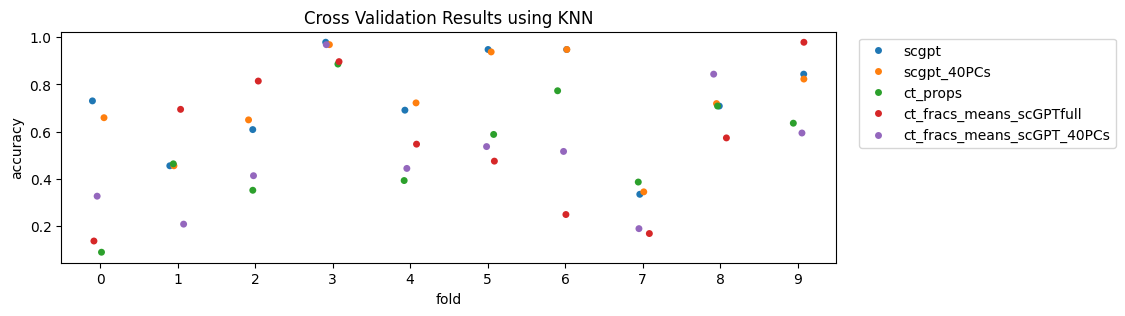

In [277]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(ds_results['KNN']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using KNN")

# Show the plot
plt.show()

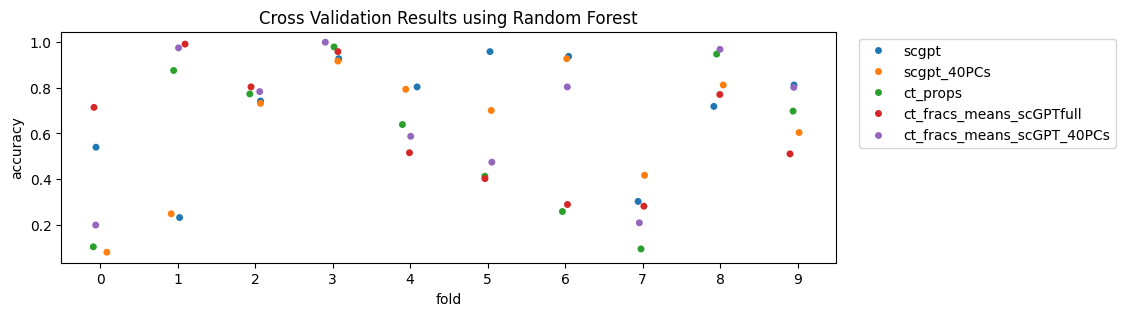

In [278]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(ds_results['random_forest']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using Random Forest")

# Show the plot
plt.show()

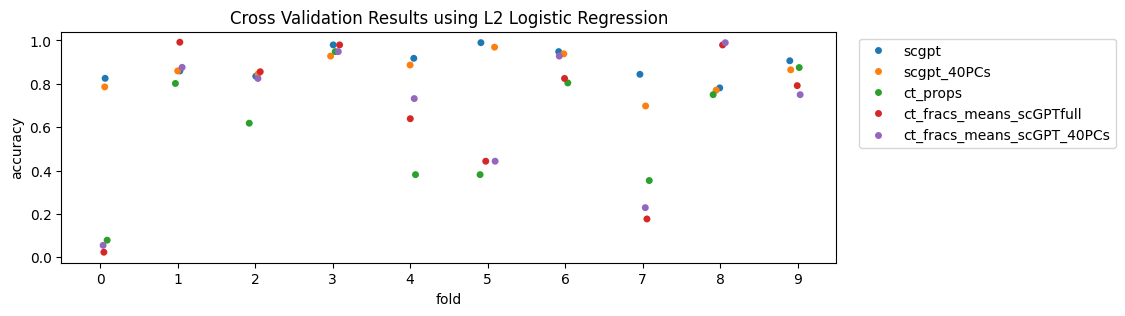

In [279]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(ds_results['l2_logistic_regression']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using L2 Logistic Regression")

# Show the plot
plt.show()

## TO DO - significance testing, not most important for getting high level sense of where the signal is

In [ ]:
# where CTprops >> baseline, compare to closest baseline
# for every sample
from statsmodels.stats.contingency_tables import mcnemar

#for logistic regression, are scgpt and ctprops_scgpt significantly different?

#what info can i pull out of nestedCV score? that might determine what ype of stat test is possible to do easily


In [ ]:
# check significance of promising results

# need to record per-sample predictions and then FOR SAMPLES where models disagree, can run either binomial or wilcoxon signed-rank test


# task 2: predict tissue of origin, but only using shared cell types 
#### note: there could be some potential confounding factors here (also above), like whether cell is labeled as just T cell or as a subtype 

In [225]:
np.sum(tissue_general_adata.obs[["tissue_general","cell_type"]].drop_duplicates().groupby("cell_type").size()==5)

15

In [228]:
ct_tmp = tissue_general_adata.obs[["tissue_general","cell_type"]].drop_duplicates().groupby("cell_type").size()[tissue_general_adata.obs[["tissue_general","cell_type"]].drop_duplicates().groupby("cell_type").size()==5].index
ct_tmp

Index(['B cell', 'CD4-positive, alpha-beta T cell',
       'CD8-positive, alpha-beta T cell', 'T cell', 'classical monocyte',
       'conventional dendritic cell', 'macrophage', 'mast cell',
       'natural killer cell', 'neutrophil', 'non-classical monocyte',
       'plasma cell', 'plasmacytoid dendritic cell', 'progenitor cell',
       'regulatory T cell'],
      dtype='object', name='cell_type')

## define sample pool, target, X, splits for this task

### define sample_pool for this target - samples that contain at least some of these cell types

In [248]:
target_col = 'tissue_general'

sample_pool = tissue_general_adata[tissue_general_adata.obs.cell_type.isin(ct_tmp)].obs.pseudosample_id.drop_duplicates()
len(sample_pool)


869

### define target, and limit/order by sample_pool

In [249]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [250]:
labels

array(['blood', 'brain', 'breast', 'lung', 'small intestine'],
      dtype=object)

In [251]:
targets.value_counts()/len(targets)

0    0.234753
3    0.222094
2    0.209436
1    0.194476
4    0.139241
Name: count, dtype: float64

### splits for leave one (dataset) out cross validation

In [252]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=10)
groups = adata.obs.set_index(sample_col).loc[sample_pool, 'dataset_id'].reset_index().drop_duplicates()['dataset_id']
splits = list(group_kfold.split(sample_pool, groups=groups)) #if don't convert to list, iterator is exhausted after one use


In [254]:
for (train_index, test_index) in splits:
    print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool.iloc[test_index],'dataset_id'].drop_duplicates()))
    print("targets in test fold:\n", targets.iloc[test_index].value_counts())
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

datasets reserved for test fold:  ['842c6f5d-4a94-4eef-8510-8c792d1124bc']
targets in test fold:
 2    126
Name: count, dtype: int64
n samples in train:  743
n samples in test:  126


datasets reserved for test fold:  ['56c4912d-2bae-4b64-98f2-af8a84389208']
targets in test fold:
 1    116
Name: count, dtype: int64
n samples in train:  753
n samples in test:  116


datasets reserved for test fold:  ['1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1']
targets in test fold:
 3    84
1     7
Name: count, dtype: int64
n samples in train:  778
n samples in test:  91


datasets reserved for test fold:  ['cf83c98a-3791-4537-bbde-a719f6d73c13', '3faad104-2ab8-4434-816d-474d8d2641db', '59b69042-47c2-47fd-ad03-d21beb99818f', '456e8b9b-f872-488b-871d-94534090a865']
targets in test fold:
 0    77
Name: count, dtype: int64
n samples in train:  792
n samples in test:  77


datasets reserved for test fold:  ['0ba636a1-4754-4786-a8be-7ab3cf760fd6', '0ba16f4b-cb87-4fa3-9363-19fc51eec6e7', '8e47ed12-c658-4252-b126-

## create pseudobulk embeddings to use downstream

In [256]:
adata = tissue_general_adata[tissue_general_adata.obs.cell_type.isin(ct_tmp)]
sample_col = 'pseudosample_id'

In [257]:
pbulk_embs = {}

#### scGPT

In [258]:
emb_name = 'scgpt'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

#### scGPT -> 40 PCs

In [259]:
emb_name = 'scgpt'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs['scgpt_40PCs'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props

In [260]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df.fillna(0) # replace nan with 0 
pbulk_embs['ct_props'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props + mean embedding based on scGPT

In [261]:
#get mean embedding per cell type

emb_name = 'scgpt'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# reset index
pseudobulk_input = pseudobulk_input.reset_index()

# Pivot the dataframe - cell types that dont exist in a given sample - fill 0 for mean expression
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type').fillna(0)

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [262]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True).fillna(0)

#### cell type props + mean embedding based on scGPT+40PCs

In [263]:
#get mean embedding per cell type

emb_name = 'scgpt'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# reset index
pseudobulk_input = pseudobulk_input.reset_index()

# Pivot the dataframe - cell types that dont exist in a given sample - fill 0 for mean expression
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type').fillna(0)

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [264]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPT_40PCs'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

### limit/order pseudobulk embeddings by sample_pool

In [265]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [266]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", val_majclass_bline_accs)
print("mean accuracy: ", np.mean(val_majclass_bline_accs))

baseline accuracy on K val sets:  [0, 0, 0, 0, 0.2077922077922078, 0.14285714285714285, 0.06493506493506493, 0.13157894736842105, 0.02631578947368421, 0.09210526315789473]
mean accuracy:  0.06655844155844155


## Evaluate models using nested GroupKFold CV

In [267]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=group_kfold, groups=groups)
    
    print("Nested CV Score: ", nested_score.mean())
    
    return nested_score

In [268]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest': (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}),
    #'l1_logistic_regression': (LogisticRegression(max_iter=500, solver='saga', penalty='l1'), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]}),
    'l2_logistic_regression': (LogisticRegression(max_iter=500, penalty='l2'), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]})
}


In [269]:
tissue_results_sharedctonly = {}
for model in model_param_dict:
    print("--------- {} ----------".format(model))
    tissue_results_sharedctonly[model] = {}
    for emb in this_pbulk_embs:
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        tissue_results_sharedctonly[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- KNN ----------
embedding:  scgpt
shape of embedding:  (869, 512)
Nested CV Score:  0.3304752416367661


embedding:  scgpt_40PCs
shape of embedding:  (869, 40)
Nested CV Score:  0.3252002987937652


embedding:  ct_props
shape of embedding:  (869, 15)
Nested CV Score:  0.28003412195789695


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (869, 7695)
Nested CV Score:  0.30177617301029286


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding:  (869, 615)
Nested CV Score:  0.36481190215309994




--------- random_forest ----------
embedding:  scgpt
shape of embedding:  (869, 512)
Nested CV Score:  0.3999960565750039


embedding:  scgpt_40PCs
shape of embedding:  (869, 40)
Nested CV Score:  0.3522705062632467


embedding:  ct_props
shape of embedding:  (869, 15)
Nested CV Score:  0.315724611142034


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (869, 7695)
Nested CV Score:  0.30136442504863553


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding: 

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Nested CV Score:  0.37935401964440074


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (869, 7695)
Nested CV Score:  0.4465080745026298


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding:  (869, 615)
Nested CV Score:  0.4885028764339109






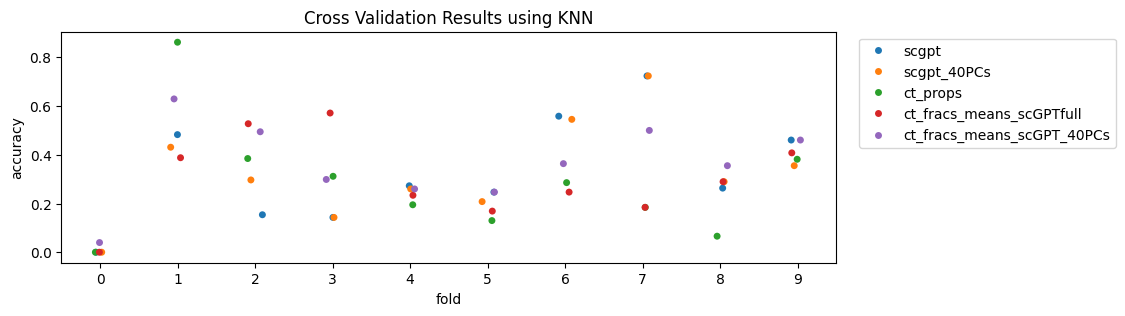

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(tissue_results_sharedctonly['KNN']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using KNN")

# Show the plot
plt.show()

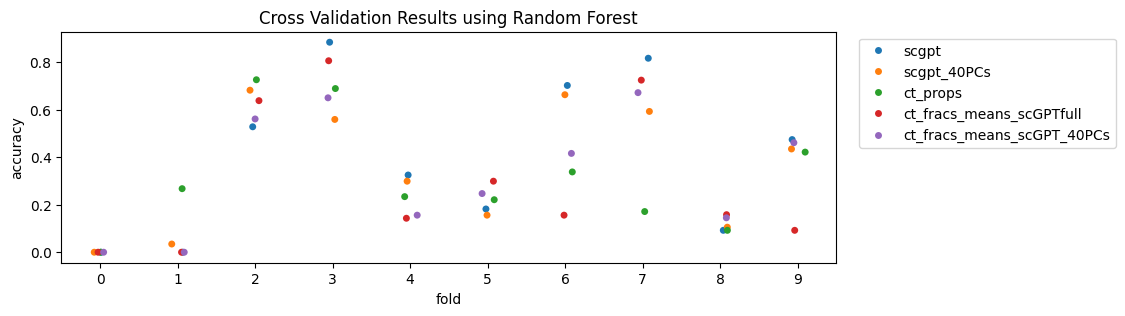

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(tissue_results_sharedctonly['random_forest']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using Random Forest")

# Show the plot
plt.show()

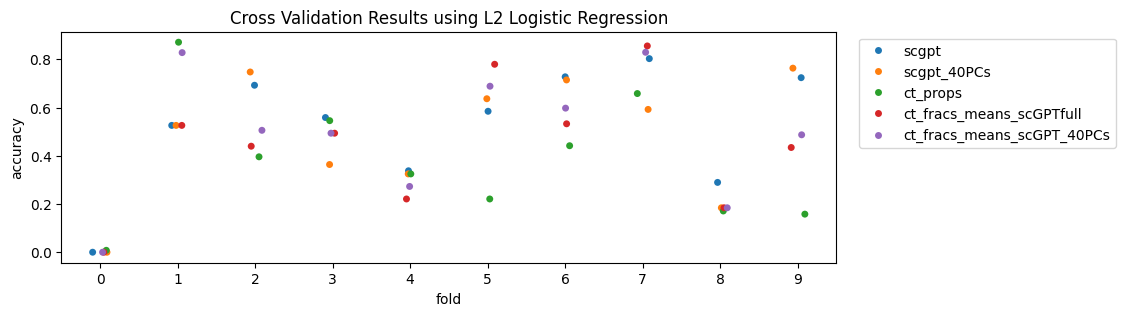

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(tissue_results_sharedctonly['l2_logistic_regression']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using L2 Logistic Regression")

# Show the plot
plt.show()

## TO DO - significance testing, not most important for getting high level sense of where the signal is

In [ ]:
# where CTprops >> baseline, compare to closest baseline
# for every sample
from statsmodels.stats.contingency_tables import mcnemar

#for logistic regression, are scgpt and ctprops_scgpt significantly different?

#what info can i pull out of nestedCV score? that might determine what ype of stat test is possible to do easily


# task 3: predict disease state in XXTISSUE samples

## pull relevant adata from CZI census

In [2]:
with cellxgene_census.open_soma() as census:

    # Reads SOMADataFrame as a slice
    cell_metadata = census["census_data"]["homo_sapiens"].obs.read(
        value_filter = "is_primary_data == True"
    )

    # Concatenates results to pyarrow.Table
    cell_metadata = cell_metadata.concat()

    # Converts to pandas.DataFrame
    cell_metadata = cell_metadata.to_pandas()

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


In [3]:
#using combo of donor_id, dataset, assay, age, disease, tissue as a unique sample
sample_proxies = cell_metadata.loc[cell_metadata.suspension_type=="cell",['donor_id','dataset_id','assay','development_stage','disease', 'tissue','tissue_general']].drop_duplicates()

In [284]:
sample_proxies.groupby(["tissue","disease"]).size().sort_values(ascending=False)[:15]

tissue              disease                     
blood               normal                          1805
                    COVID-19                         538
lung                normal                           177
blood               systemic lupus erythematosus     164
breast              normal                           157
lung                lung adenocarcinoma              147
brain               glioblastoma                     115
ileum               Crohn disease                     90
respiratory airway  normal                            75
ileum               normal                            67
gonad               normal                            66
kidney              normal                            64
bone marrow         normal                            63
                    plasma cell myeloma               55
liver               normal                            54
dtype: int64

# task 3a: blood, distinguish normal vs covid-19

### choose a random sampling of samples that won't be too large for memory

In [4]:
select_sample_proxies = cell_metadata.loc[(cell_metadata.suspension_type=="cell") & (cell_metadata.tissue_general=='blood') & (cell_metadata.disease.isin(["normal","COVID-19"])),['donor_id', 'dataset_id','assay','development_stage','disease', 'tissue','tissue_general']].drop_duplicates()

In [287]:
select_sample_proxies.disease.value_counts()

disease
normal      1810
COVID-19     538
Name: count, dtype: int64

In [5]:
# choose MIN_SAMPLES examples from one target label to get balanced sample from those sample proxies -- merge with cell info to get all cells, in order to grab soma_joinid
select_cells = select_sample_proxies.groupby("disease").sample(n=min(select_sample_proxies.disease.value_counts())).merge(cell_metadata)

In [291]:
len(select_cells)

4605341

In [292]:
#num "samples" pulled
len(select_cells[['donor_id', 'dataset_id','assay','development_stage','disease', 'tissue','tissue_general']].drop_duplicates())

1076

In [6]:
with cellxgene_census.open_soma() as census:
    covidvsnormal_blood_adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Homo sapiens",
        measurement_name = "RNA",
        obs_coords = select_cells.soma_joinid.tolist(),
        column_names = {"obs": ["soma_joinid", "assay", "cell_type", "tissue", "tissue_general", "suspension_type", "development_stage", "disease", "donor_id","dataset_id"]},
        obs_embeddings = ["scgpt"]
    )

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


In [7]:
adata = covidvsnormal_blood_adata

In [8]:
adata

AnnData object with n_obs × n_vars = 4641436 × 60664
    obs: 'soma_joinid', 'assay', 'cell_type', 'tissue', 'tissue_general', 'suspension_type', 'development_stage', 'disease', 'donor_id', 'dataset_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scgpt'

In [9]:
# add pseudosample_id
sample_df = adata.obs[['dataset_id','assay','disease','donor_id', 'tissue','tissue_general']].drop_duplicates()
sample_df['pseudosample_id'] = np.arange(len(sample_df))+1
sample_df

,dataset_id,assay,disease,donor_id,tissue,tissue_general,pseudosample_id
0,5af90777-6760-4003-9dba-8f945fec6fdf,10x 5' transcription profiling,normal,PD43948,blood,blood,1
61,5af90777-6760-4003-9dba-8f945fec6fdf,10x 5' transcription profiling,normal,PD45815,blood,blood,2
739,5af90777-6760-4003-9dba-8f945fec6fdf,10x 5' transcription profiling,normal,PD47465,blood,blood,3
16161,b0e547f0-462b-4f81-b31b-5b0a5d96f537,10x 5' v2,normal,SG_HEL_H02a,blood,blood,4
17015,b0e547f0-462b-4f81-b31b-5b0a5d96f537,10x 5' v2,normal,SG_HEL_H09a,blood,blood,5
...,...,...,...,...,...,...,...
4629070,456e8b9b-f872-488b-871d-94534090a865,Seq-Well,COVID-19,C6,blood,blood,1072
4630963,456e8b9b-f872-488b-871d-94534090a865,Seq-Well,COVID-19,C7,blood,blood,1073
4634327,456e8b9b-f872-488b-871d-94534090a865,Seq-Well,normal,H2,blood,blood,1074
4636268,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,normal,Donor45,blood,blood,1075


In [10]:
adata.obs = adata.obs.merge(sample_df)

## create pseudobulk embeddings to use downstream

In [11]:
sample_col = 'pseudosample_id'

In [12]:
pbulk_embs = {}

#### scGPT

In [13]:
emb_name = 'scgpt'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

#### scGPT -> 40 PCs

In [14]:
emb_name = 'scgpt'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs['scgpt_40PCs'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props

In [15]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df.fillna(0) # replace nan with 0 
pbulk_embs['ct_props'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props + mean embedding based on scGPT

In [16]:
#get mean embedding per cell type

emb_name = 'scgpt'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# reset index
pseudobulk_input = pseudobulk_input.reset_index()

# Pivot the dataframe - cell types that dont exist in a given sample - fill 0 for mean expression
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type').fillna(0)

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [17]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True).fillna(0)

#### cell type props + mean embedding based on scGPT+40PCs

In [18]:
#get mean embedding per cell type

emb_name = 'scgpt'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# reset index
pseudobulk_input = pseudobulk_input.reset_index()

# Pivot the dataframe - cell types that dont exist in a given sample - fill 0 for mean expression
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type').fillna(0)

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [19]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPT_40PCs'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [20]:
target_col = 'disease'

#get sample IDs that are not NA for this target
notNA_samples = adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
print("this target has {} non-NA samples".format(len(notNA_samples)))


this target has 1076 non-NA samples


In [21]:
sample_pool = np.array(notNA_samples)
print(len(sample_pool))

1076


### define target, and limit/order by sample_pool

In [22]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [23]:
labels

array(['COVID-19', 'normal'], dtype=object)

In [24]:
targets.value_counts()/len(targets)

1    0.5
0    0.5
Name: count, dtype: float64

### splits for leave one (dataset) out cross validation

In [25]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=10)
groups = adata.obs.set_index(sample_col).loc[sample_pool, 'dataset_id'].reset_index().drop_duplicates()['dataset_id']
splits = list(group_kfold.split(sample_pool, groups=groups)) #if don't convert to list, iterator is exhausted after one use


In [26]:
for (train_index, test_index) in splits:
    print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index],'dataset_id'].drop_duplicates()))
    print("targets in test fold:\n", targets.iloc[test_index].value_counts())
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

datasets reserved for test fold:  ['3faad104-2ab8-4434-816d-474d8d2641db']
targets in test fold:
 1    303
Name: count, dtype: int64
n samples in train:  773
n samples in test:  303


datasets reserved for test fold:  ['9dbab10c-118d-496b-966a-67f1763a6b7d']
targets in test fold:
 0    158
1      7
Name: count, dtype: int64
n samples in train:  911
n samples in test:  165


datasets reserved for test fold:  ['b0e547f0-462b-4f81-b31b-5b0a5d96f537']
targets in test fold:
 1    152
Name: count, dtype: int64
n samples in train:  924
n samples in test:  152


datasets reserved for test fold:  ['ebc2e1ff-c8f9-466a-acf4-9d291afaf8b3']
targets in test fold:
 0    102
1      3
Name: count, dtype: int64
n samples in train:  971
n samples in test:  105


datasets reserved for test fold:  ['c7775e88-49bf-4ba2-a03b-93f00447c958']
targets in test fold:
 0    86
1     8
Name: count, dtype: int64
n samples in train:  982
n samples in test:  94


datasets reserved for test fold:  ['01ad3cd7-3929-4654-8

### limit/order pseudobulk embeddings by sample_pool

In [27]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [28]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", val_majclass_bline_accs)
print("mean accuracy: ", np.mean(val_majclass_bline_accs))

baseline accuracy on K val sets:  [0, 0.04242424242424243, 0, 0.02857142857142857, 0.0851063829787234, 0.05263157894736842, 0.2, 0.18, 0.42, 0.28]
mean accuracy:  0.12887336329217627


## Evaluate models using nested GroupKFold CV

In [29]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=group_kfold, groups=groups)
    
    print("Nested CV Score: ", nested_score.mean())
    
    return nested_score

In [30]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest': (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}),
    #'l1_logistic_regression': (LogisticRegression(max_iter=500, solver='saga', penalty='l1'), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]}),
    'l2_logistic_regression': (LogisticRegression(max_iter=500, penalty='l2'), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]})
}


In [31]:
blood_covVSnormal_results = {}
for model in model_param_dict:
    print("--------- {} ----------".format(model))
    blood_covVSnormal_results[model] = {}
    for emb in this_pbulk_embs:
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        blood_covVSnormal_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- KNN ----------
embedding:  scgpt
shape of embedding:  (1076, 512)
Nested CV Score:  0.7829796220063536


embedding:  scgpt_40PCs
shape of embedding:  (1076, 40)
Nested CV Score:  0.785378061850338


embedding:  ct_props
shape of embedding:  (1076, 120)
Nested CV Score:  0.5265483427482085


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (1076, 61560)
Nested CV Score:  0.6559946733995108


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding:  (1076, 4920)
Nested CV Score:  0.6058737345979038




--------- random_forest ----------
embedding:  scgpt
shape of embedding:  (1076, 512)
Nested CV Score:  0.7871689014606148


embedding:  scgpt_40PCs
shape of embedding:  (1076, 40)
Nested CV Score:  0.6885140520451022


embedding:  ct_props
shape of embedding:  (1076, 120)
Nested CV Score:  0.561644171328027


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (1076, 61560)
Nested CV Score:  0.5735850167003582


embedding:  ct_fracs_means_scGPT_40PCs
shape of em

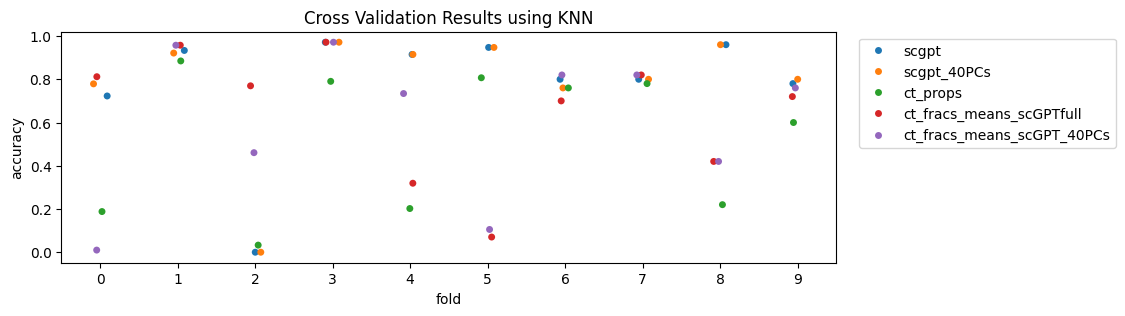

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(blood_covVSnormal_results['KNN']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using KNN")

# Show the plot
plt.show()

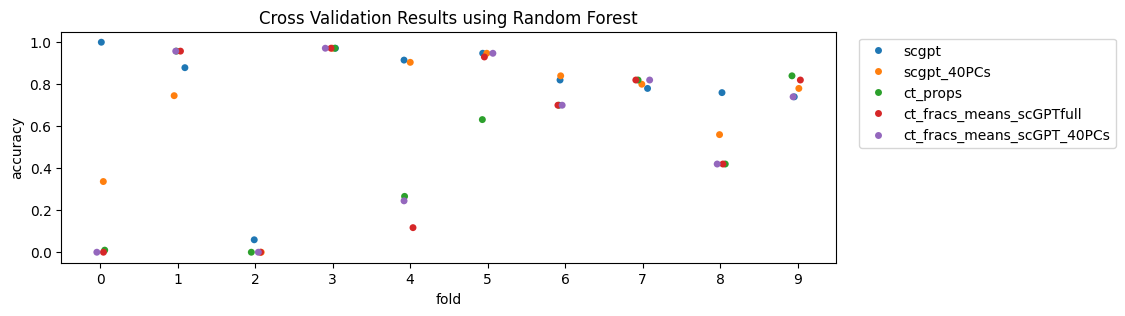

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(blood_covVSnormal_results['random_forest']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using Random Forest")

# Show the plot
plt.show()

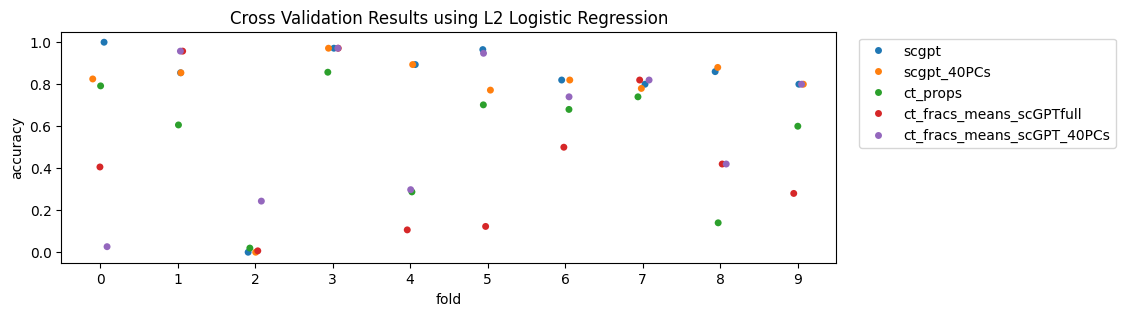

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(blood_covVSnormal_results['l2_logistic_regression']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using L2 Logistic Regression")

# Show the plot
plt.show()

# task 3b: blood, distinguish normal vs lupus

### choose a random sampling of samples that won't be too large for memory

In [35]:
select_sample_proxies = cell_metadata.loc[(cell_metadata.suspension_type=="cell") & (cell_metadata.tissue_general=='blood') & (cell_metadata.disease.isin(["normal","systemic lupus erythematosus"])),['donor_id', 'dataset_id','assay','development_stage','disease', 'tissue','tissue_general']].drop_duplicates()

In [36]:
select_sample_proxies.disease.value_counts()

disease
normal                          1810
systemic lupus erythematosus     164
Name: count, dtype: int64

In [37]:
# choose MIN_SAMPLES examples from one target label to get balanced sample from those sample proxies -- merge with cell info to get all cells, in order to grab soma_joinid
select_cells = select_sample_proxies.groupby("disease").sample(n=min(select_sample_proxies.disease.value_counts())).merge(cell_metadata)

In [38]:
len(select_cells)

1127558

In [39]:
#num "samples" pulled
len(select_cells[['donor_id', 'dataset_id','assay','development_stage','disease', 'tissue','tissue_general']].drop_duplicates())

328

In [41]:
with cellxgene_census.open_soma() as census:
    covidvsnormal_blood_adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Homo sapiens",
        measurement_name = "RNA",
        obs_coords = select_cells.soma_joinid.tolist(),
        column_names = {"obs": ["soma_joinid", "assay", "cell_type", "tissue", "tissue_general", "suspension_type", "development_stage", "disease", "donor_id","dataset_id"]},
        obs_embeddings = ["scgpt"]
    )

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


In [42]:
adata = covidvsnormal_blood_adata

In [43]:
adata

AnnData object with n_obs × n_vars = 1127558 × 60664
    obs: 'soma_joinid', 'assay', 'cell_type', 'tissue', 'tissue_general', 'suspension_type', 'development_stage', 'disease', 'donor_id', 'dataset_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scgpt'

In [44]:
# add pseudosample_id
sample_df = adata.obs[['dataset_id','assay','disease','donor_id', 'tissue','tissue_general']].drop_duplicates()
sample_df['pseudosample_id'] = np.arange(len(sample_df))+1
sample_df

,dataset_id,assay,disease,donor_id,tissue,tissue_general,pseudosample_id
0,5af90777-6760-4003-9dba-8f945fec6fdf,10x 5' transcription profiling,normal,PD47512,blood,blood,1
6427,b0e547f0-462b-4f81-b31b-5b0a5d96f537,10x 5' v2,normal,SG_HEL_H06a,blood,blood,2
7812,b0e547f0-462b-4f81-b31b-5b0a5d96f537,10x 5' v2,normal,SG_HEL_H181,blood,blood,3
8979,b0e547f0-462b-4f81-b31b-5b0a5d96f537,10x 5' v2,normal,SG_HEL_H191,blood,blood,4
12379,b0e547f0-462b-4f81-b31b-5b0a5d96f537,10x 5' v2,normal,SG_HEL_H052,blood,blood,5
...,...,...,...,...,...,...,...
1105392,9dbab10c-118d-496b-966a-67f1763a6b7d,10x 5' v2,normal,P-HC018,blood,blood,322
1111713,9dbab10c-118d-496b-966a-67f1763a6b7d,10x 5' v2,normal,P-HC021,blood,blood,323
1117679,30cd5311-6c09-46c9-94f1-71fe4b91813c,10x 5' v1,normal,AA220534,blood,blood,324
1118554,21d3e683-80a4-4d9b-bc89-ebb2df513dde,10x 5' v1,normal,AA220907,blood,blood,325


In [45]:
adata.obs = adata.obs.merge(sample_df)

## create pseudobulk embeddings to use downstream

In [46]:
sample_col = 'pseudosample_id'

In [47]:
pbulk_embs = {}

#### scGPT

In [48]:
emb_name = 'scgpt'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

#### scGPT -> 40 PCs

In [49]:
emb_name = 'scgpt'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs['scgpt_40PCs'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props

In [50]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby(sample_col).cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index=sample_col, columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df.fillna(0) # replace nan with 0 
pbulk_embs['ct_props'] = pseudobulk_input#.loc[sample_pool,:]

#### cell type props + mean embedding based on scGPT

In [51]:
#get mean embedding per cell type

emb_name = 'scgpt'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# reset index
pseudobulk_input = pseudobulk_input.reset_index()

# Pivot the dataframe - cell types that dont exist in a given sample - fill 0 for mean expression
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type').fillna(0)

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [52]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True).fillna(0)

#### cell type props + mean embedding based on scGPT+40PCs

In [53]:
#get mean embedding per cell type

emb_name = 'scgpt'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# reset index
pseudobulk_input = pseudobulk_input.reset_index()

# Pivot the dataframe - cell types that dont exist in a given sample - fill 0 for mean expression
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type').fillna(0)

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

In [54]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPT_40PCs'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [55]:
target_col = 'disease'

#get sample IDs that are not NA for this target
notNA_samples = adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
print("this target has {} non-NA samples".format(len(notNA_samples)))


this target has 326 non-NA samples


In [56]:
sample_pool = np.array(notNA_samples)
print(len(sample_pool))

326


### define target, and limit/order by sample_pool

In [57]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [58]:
labels

array(['normal', 'systemic lupus erythematosus'], dtype=object)

In [59]:
targets.value_counts()/len(targets)

0    0.503067
1    0.496933
Name: count, dtype: float64

### splits for leave one (dataset) out cross validation

In [60]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=10)
groups = adata.obs.set_index(sample_col).loc[sample_pool, 'dataset_id'].reset_index().drop_duplicates()['dataset_id']
splits = list(group_kfold.split(sample_pool, groups=groups)) #if don't convert to list, iterator is exhausted after one use


In [61]:
for (train_index, test_index) in splits:
    print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index],'dataset_id'].drop_duplicates()))
    print("targets in test fold:\n", targets.iloc[test_index].value_counts())
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

datasets reserved for test fold:  ['218acb0f-9f2f-4f76-b90b-15a4b7c7f629']
targets in test fold:
 1    162
0      9
Name: count, dtype: int64
n samples in train:  155
n samples in test:  171


datasets reserved for test fold:  ['3faad104-2ab8-4434-816d-474d8d2641db']
targets in test fold:
 0    93
Name: count, dtype: int64
n samples in train:  233
n samples in test:  93


datasets reserved for test fold:  ['b0e547f0-462b-4f81-b31b-5b0a5d96f537']
targets in test fold:
 0    50
Name: count, dtype: int64
n samples in train:  276
n samples in test:  50


datasets reserved for test fold:  ['9dbab10c-118d-496b-966a-67f1763a6b7d']
targets in test fold:
 0    3
Name: count, dtype: int64
n samples in train:  323
n samples in test:  3


datasets reserved for test fold:  ['c7775e88-49bf-4ba2-a03b-93f00447c958']
targets in test fold:
 0    2
Name: count, dtype: int64
n samples in train:  324
n samples in test:  2


datasets reserved for test fold:  ['ebc2e1ff-c8f9-466a-acf4-9d291afaf8b3', '21d3e68

### limit/order pseudobulk embeddings by sample_pool

In [62]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [63]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", val_majclass_bline_accs)
print("mean accuracy: ", np.mean(val_majclass_bline_accs))

baseline accuracy on K val sets:  [0.05263157894736842, 0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
mean accuracy:  0.6052631578947368


## Evaluate models using nested GroupKFold CV

In [64]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=group_kfold, groups=groups)
    
    print("Nested CV Score: ", nested_score.mean())
    
    return nested_score

In [65]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest': (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}),
    #'l1_logistic_regression': (LogisticRegression(max_iter=500, solver='saga', penalty='l1'), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]}),
    'l2_logistic_regression': (LogisticRegression(max_iter=500, penalty='l2'), {'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]})
}


In [66]:
lupus_results = {}
for model in model_param_dict:
    print("--------- {} ----------".format(model))
    lupus_results[model] = {}
    for emb in this_pbulk_embs:
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        lupus_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- KNN ----------
embedding:  scgpt
shape of embedding:  (326, 512)
Nested CV Score:  0.6660158460667798


embedding:  scgpt_40PCs
shape of embedding:  (326, 40)
Nested CV Score:  0.6660158460667798


embedding:  ct_props
shape of embedding:  (326, 79)
Nested CV Score:  0.4552631578947368


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (326, 40527)
Nested CV Score:  0.5552631578947368


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding:  (326, 3239)
Nested CV Score:  0.4014997170345218




--------- random_forest ----------
embedding:  scgpt
shape of embedding:  (326, 512)
Nested CV Score:  0.8988115449915111


embedding:  scgpt_40PCs
shape of embedding:  (326, 40)
Nested CV Score:  0.8491341256366723


embedding:  ct_props
shape of embedding:  (326, 79)
Nested CV Score:  0.8552631578947368


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (326, 40527)
Nested CV Score:  0.9052631578947368


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding: 

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 968, i

Nested CV Score:  nan


embedding:  scgpt_40PCs
shape of embedding:  (326, 40)


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 968, i

Nested CV Score:  nan


embedding:  ct_props
shape of embedding:  (326, 79)


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 968, i

Nested CV Score:  nan


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (326, 40527)


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 968, i

Nested CV Score:  nan


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding:  (326, 3239)
Nested CV Score:  nan






/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/model_selection/_search.py", line 968, i

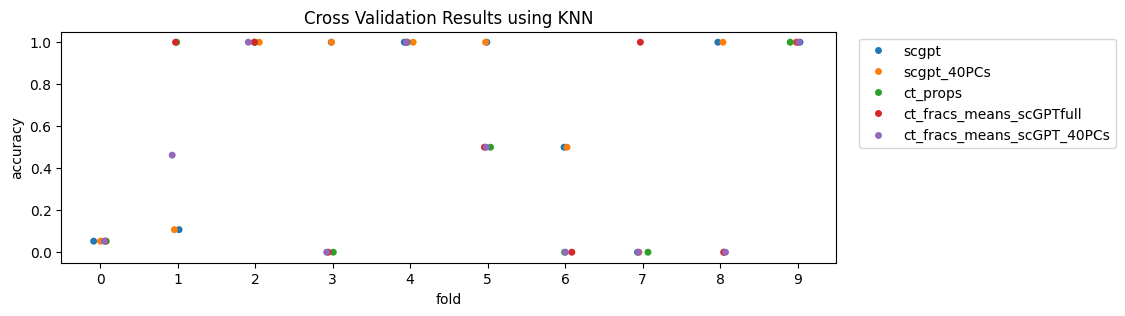

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(lupus_results['KNN']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using KNN")

# Show the plot
plt.show()

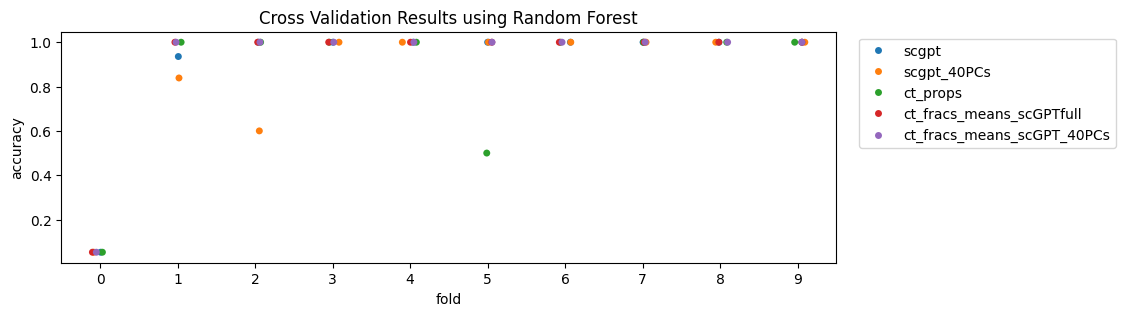

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(lupus_results['random_forest']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using Random Forest")

# Show the plot
plt.show()

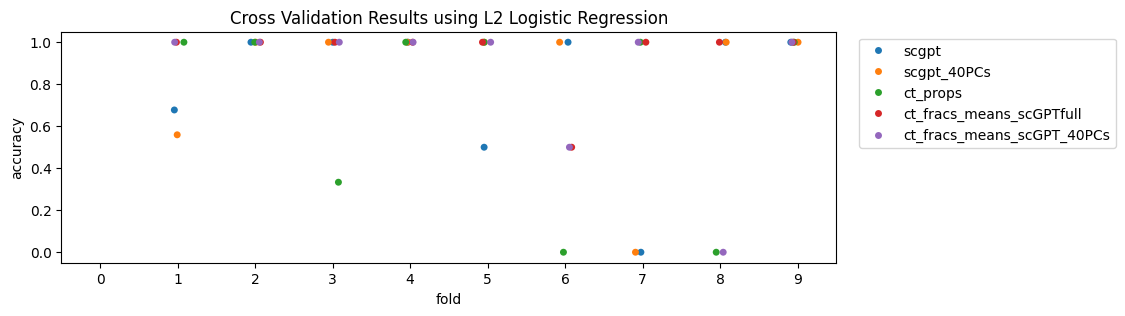

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(lupus_results['l2_logistic_regression']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using L2 Logistic Regression")

# Show the plot
plt.show()